In [1]:
import sys
sys.path.append('/home/cara/Documents/reddit_analysis_code')
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt

In [2]:
thread_data = pickle.load(open('clean_5_thread_data.p', 'rb'))

# Thread size

In [3]:
thread_info = {}
for key in thread_data:
    key_thread_info = thread_data[key][['thread_id', 'id']].groupby('thread_id').count()
    key_thread_info = key_thread_info.rename(columns={'id': 'thread_size'}).reset_index()
    author_data = (thread_data[key][['thread_id', 'author']].drop_duplicates().groupby('thread_id').count()).rename(columns={'author': 'authors'}).reset_index()
    thread_info[key] = pd.concat((key_thread_info, author_data[['authors']]), axis=1)

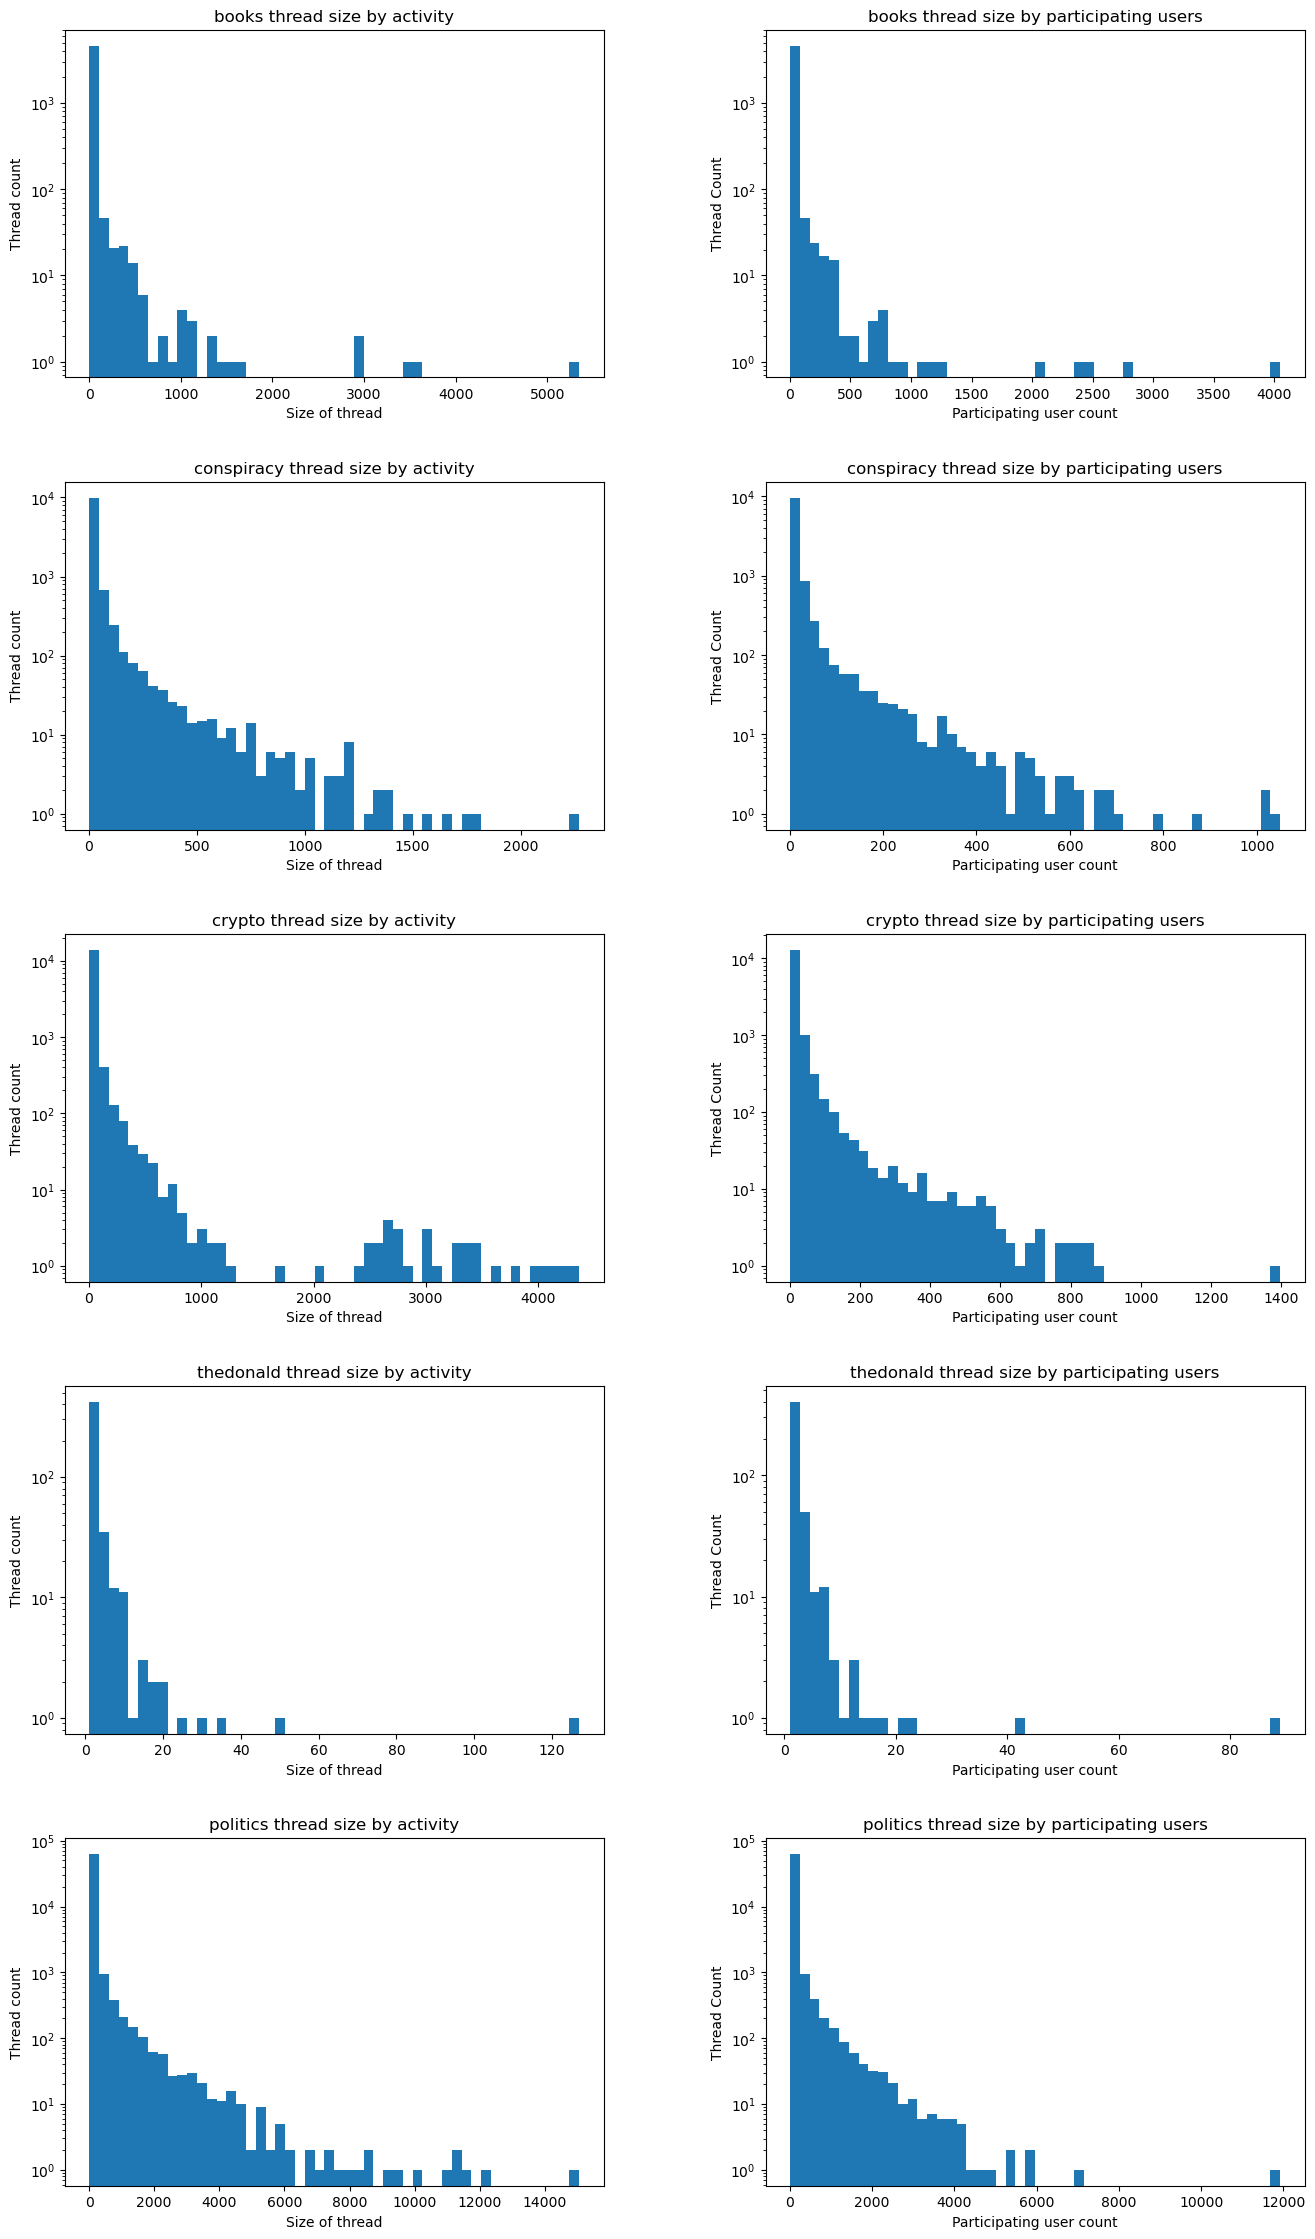

In [5]:
fig, axes = plt.subplots(5,2, figsize=(16,28))

i = 0
for key in thread_info:
    thread_info[key].hist(column='thread_size', grid=False, bins=50, log=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{key} thread size by activity')
    axes[i, 0].set_xlabel('Size of thread')
    axes[i, 0].set_ylabel('Thread count')


    thread_info[key].hist(column='authors', grid=False, bins=50, log=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{key} thread size by participating users')
    axes[i, 1].set_xlabel('Participating user count')
    axes[i, 1].set_ylabel('Thread Count')

    i+=1


plt.show()

# Levels

In [6]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

for key in thread_data:
    level_data = thread_data[key][['thread_id', 'level']].groupby('thread_id').aggregate(func=['mean', q1, 'median', q3, 'max']).reset_index()
    rename_dict = {}
    for column in level_data['level'].columns:
        rename_dict[column] = f"level_{column}"

    level_data = level_data['level'].rename(columns=rename_dict)

    thread_info[key] = pd.concat((thread_info[key], level_data), axis=1)

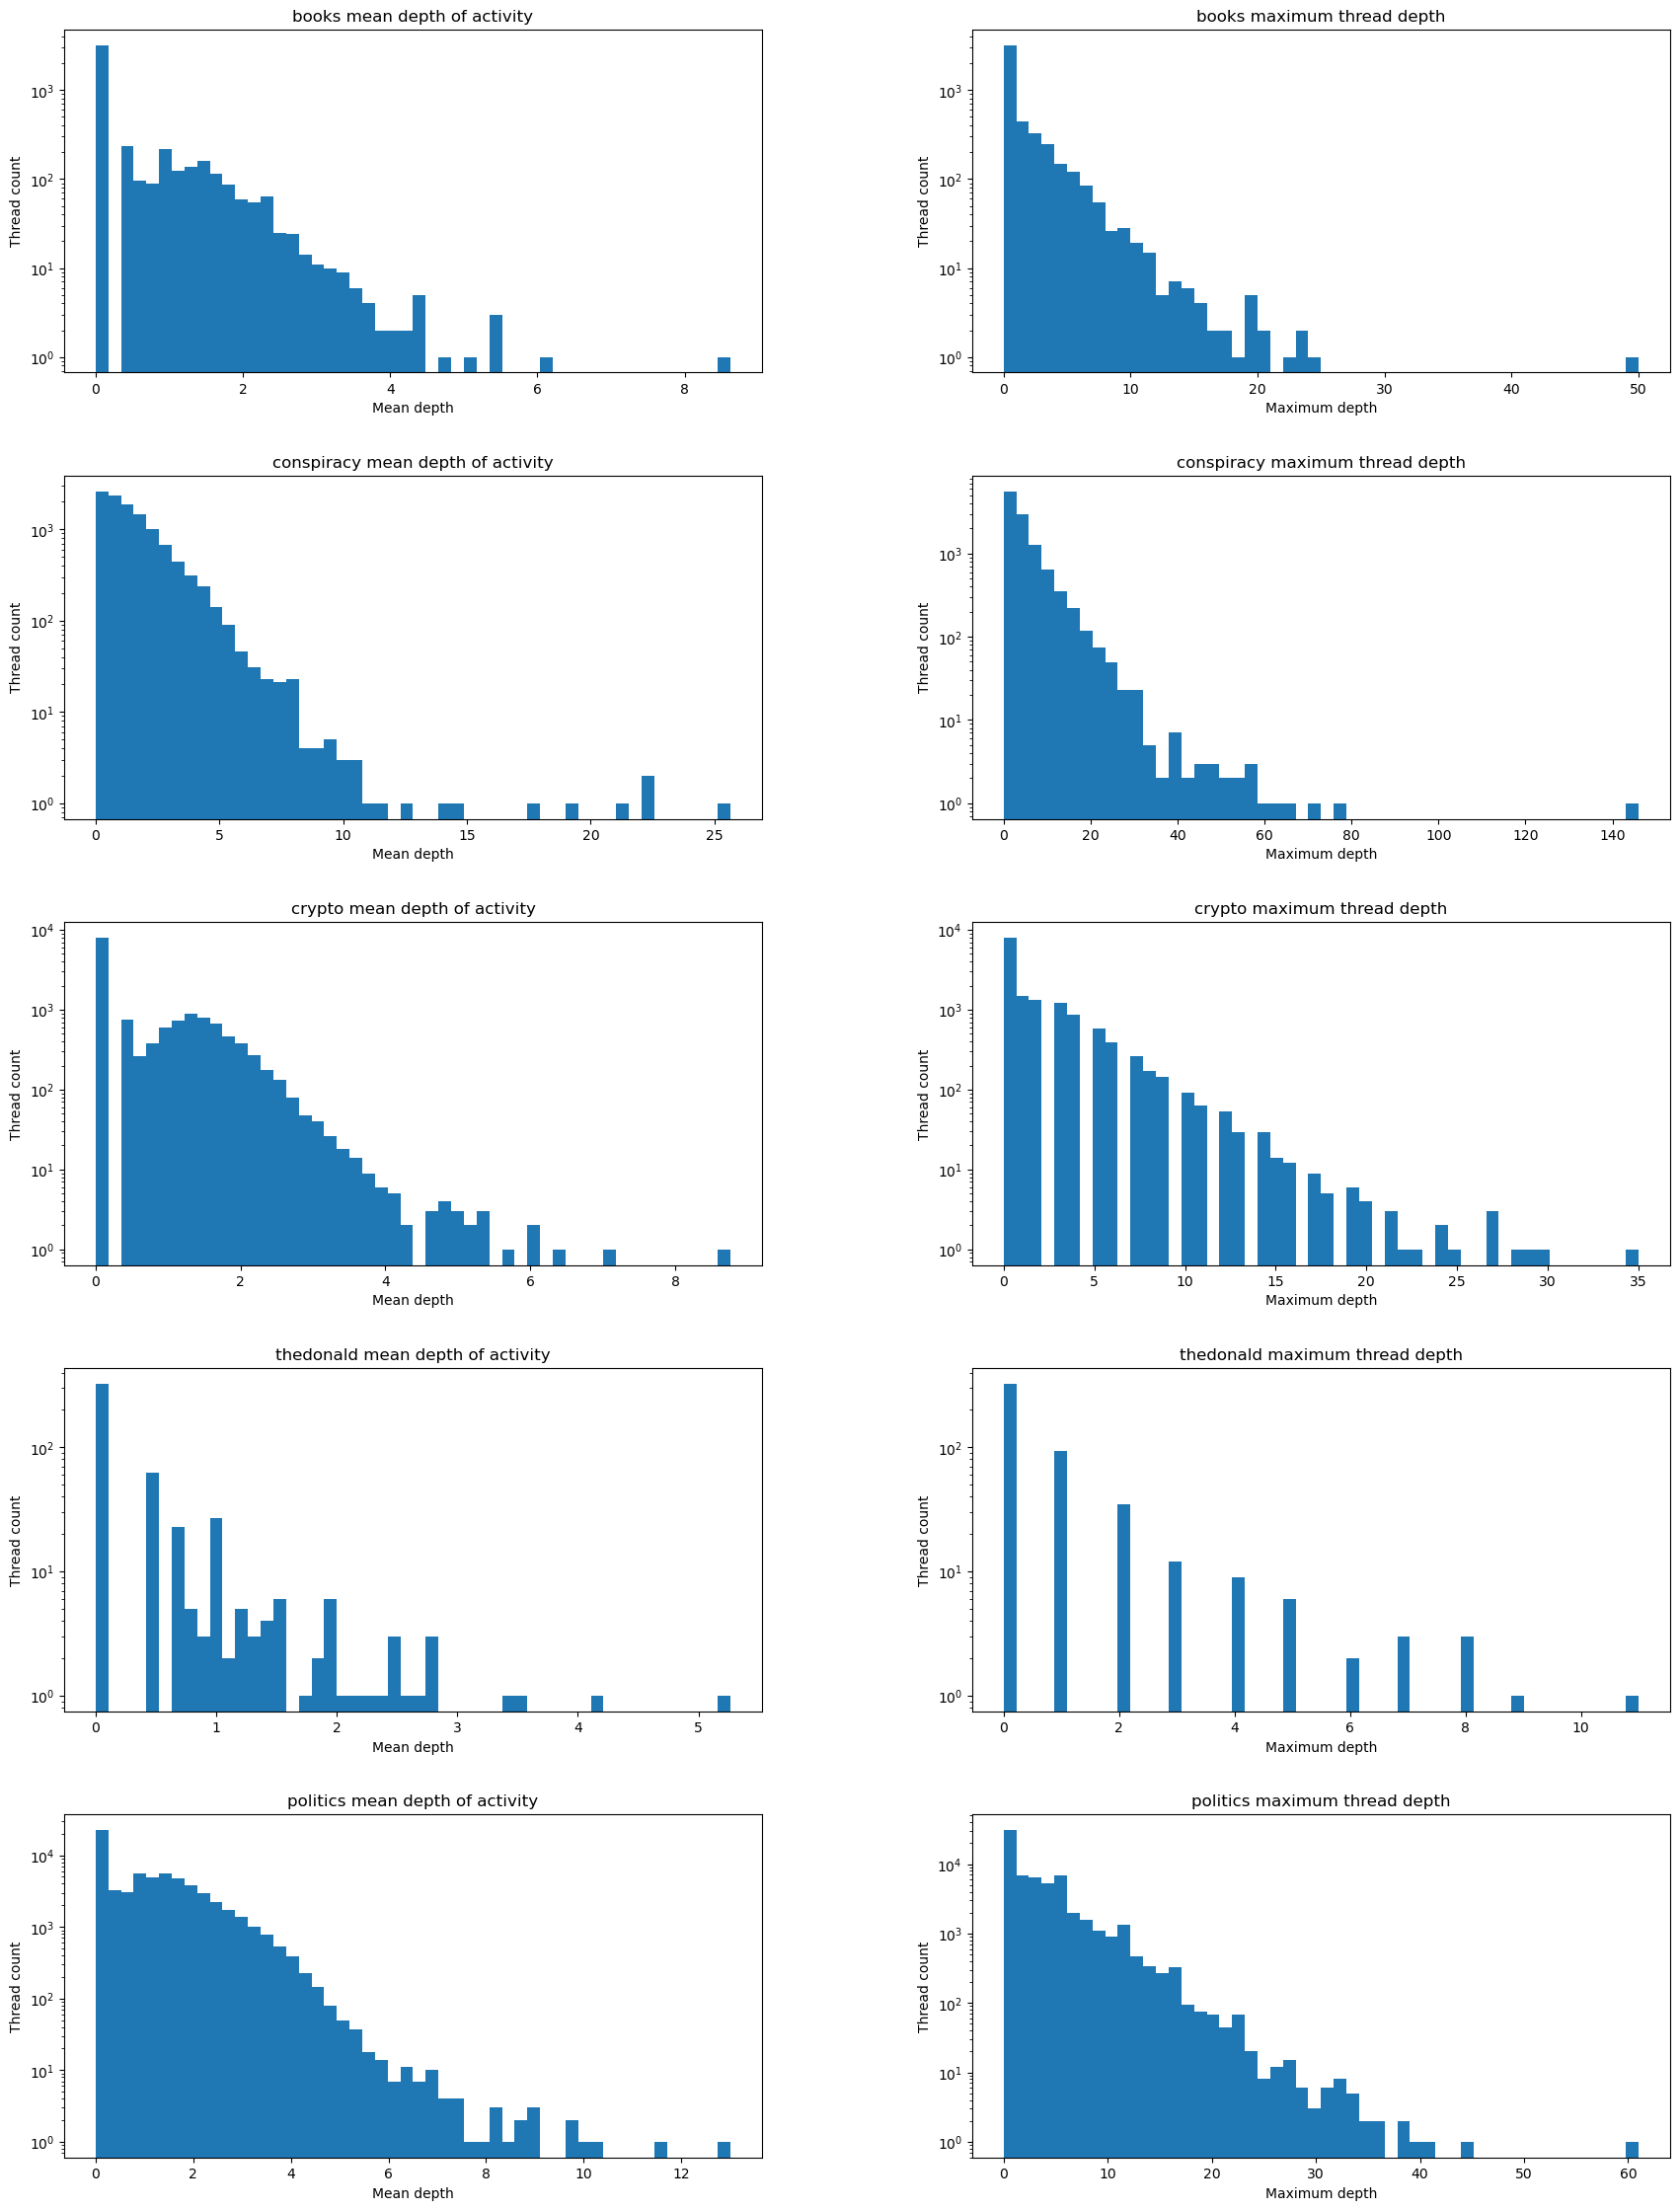

In [7]:
fig, axes = plt.subplots(5,2, figsize=(21,28))

i=0
for key in thread_info:
    thread_info[key].hist(column=['level_mean', 'level_max'], grid=False, bins=50, log=True, ax=axes[i])

    axes[i, 0].set_title(f'{key} mean depth of activity')
    axes[i, 0].set_xlabel('Mean depth')
    axes[i, 0].set_ylabel('Thread count')

    axes[i, 1].set_title(f'{key} maximum thread depth')
    axes[i, 1].set_xlabel('Maximum depth')
    axes[i, 1].set_ylabel('Thread count')

    i += 1

plt.show()

In [8]:
level_counts = {}
max_lvl = 5
thread_info_lvls = {}
lvl_sums = {}

rename_dict = dict(zip([f'level_{i}_count' for i in range(0,max_lvl + 1)], [f'level_{i}_cumsum' for i in range(0,max_lvl + 1)]))


for key in thread_data:
    level_counts[key] = thread_data[key][['thread_id', 'id', 'level']].groupby(['thread_id', 'level']).count().rename(columns={'id': 'level_count'})
    thread_info_cp = thread_info[key][['thread_id']]
    for i in range(0, max_lvl+1):
        level_counter = thread_data[key].loc[thread_data[key].level == i, :][['thread_id', 'id']].groupby('thread_id').count().rename(columns={'id': f"level_{i}_count"}).reset_index()
        thread_info_cp = pd.merge(thread_info_cp, level_counter, on='thread_id', how='left').fillna(value=0)
    thread_info_lvl = pd.concat((thread_info[key], thread_info_cp[[f'level_{i}_count' for i in range(0, max_lvl + 1)]]), axis=1)

    lvl_sum = thread_info_lvl[['thread_size']+[f'level_{i}_count' for i in range(0,max_lvl + 1)]]
    lvl_sum = pd.concat((lvl_sum, lvl_sum[[f'level_{i}_count' for i in range(0,max_lvl + 1)]].cumsum(axis=1).rename(columns=rename_dict)), axis=1)[['thread_size']+[f'level_{i}_cumsum' for i in range(0,max_lvl + 1)]]

    for i in range(0,max_lvl+1):
        lvl_sum[f"level_{i}_cumsum_%"] = (lvl_sum[f"level_{i}_cumsum"])/lvl_sum['thread_size']
    
    thread_info_lvls[key] = pd.concat((thread_info_lvl, lvl_sum[[f'level_{i}_cumsum_%' for i in range(0,max_lvl + 1)]]), axis=1).drop(labels=['level_0_count'], axis=1)



In [6]:
thread_info['books']

,thread_id,thread_size,authors,level_mean,level_q1,level_median,level_q3,level_max
0,xsgu8l,1,1,0.0,0.0,0.0,0.0,0
1,xsh6qv,1,1,0.0,0.0,0.0,0.0,0
2,xshdvl,1,1,0.0,0.0,0.0,0.0,0
3,xsi14p,1,1,0.0,0.0,0.0,0.0,0
4,xsis1h,1,1,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
4771,yhubu4,1,1,0.0,0.0,0.0,0.0,0
4772,yhufba,1,1,0.0,0.0,0.0,0.0,0
4773,yhukih,1,1,0.0,0.0,0.0,0.0,0
4774,yhumfc,1,1,0.0,0.0,0.0,0.0,0


In [9]:
describe_lvl_cumsums = {}
for key in thread_info_lvls:
    key_describe_lvl_cumsums = {}
    for i in range(0, max_lvl+1):
        key_describe_lvl_cumsums[i] = (
            thread_info_lvls[key][f'level_{i}_cumsum_%'].describe())
    describe_lvl_cumsums[key] = pd.DataFrame.from_dict(key_describe_lvl_cumsums, orient='index')

In [60]:
describe_lvl_cumsums['thedonald']

,count,mean,std,min,25%,50%,75%,max
0,491.0,0.770716,0.336143,0.007874,0.5,1.0,1.0,1.0
1,491.0,0.937635,0.168485,0.142857,1.0,1.0,1.0,1.0
2,491.0,0.973259,0.105223,0.266667,1.0,1.0,1.0,1.0
3,491.0,0.986709,0.065813,0.400000,1.0,1.0,1.0,1.0
4,491.0,0.992977,0.045120,0.466667,1.0,1.0,1.0,1.0
5,491.0,0.996313,0.031818,0.533333,1.0,1.0,1.0,1.0


In [10]:
pickle.dump(thread_info, open('thread_5_info.p', 'wb'))
pickle.dump(thread_info_lvls, open('thread_5_lvls_info.p', 'wb'))

In [9]:
thread_info['books']

,thread_id,thread_size,authors,level_mean,level_q1,level_median,level_q3,level_max
0,xsgu8l,1,1,0.0,0.0,0.0,0.0,0
1,xsh6qv,1,1,0.0,0.0,0.0,0.0,0
2,xshdvl,1,1,0.0,0.0,0.0,0.0,0
3,xsi14p,1,1,0.0,0.0,0.0,0.0,0
4,xsis1h,1,1,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
4771,yhubu4,1,1,0.0,0.0,0.0,0.0,0
4772,yhufba,1,1,0.0,0.0,0.0,0.0,0
4773,yhukih,1,1,0.0,0.0,0.0,0.0,0
4774,yhumfc,1,1,0.0,0.0,0.0,0.0,0
